In [11]:
from pathlib import Path

import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from wmfdata import charting, hive


In [12]:
%matplotlib inline
charting.set_mpl_style()

In [13]:
# UPDATE FOR NEW MONTH!
# Metric month. The mediawiki_history snapshot for this month must be available.
# METRICS_MONTH_TEXT = "2019-07"
# MEDIAWIKI_HISTORY_SNAPSHOT = "2019-07"

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
first_day_month = last_month.replace(day=1)

METRICS_MONTH_TEXT = last_month.strftime("%Y-%m")
MEDIAWIKI_HISTORY_SNAPSHOT = last_month.strftime("%Y-%m")

metrics_month = pd.Period(METRICS_MONTH_TEXT)
insert_start = str(metrics_month)
insert_end = str(metrics_month + 1)
graph_start = str(metrics_month - 48)

# Update table

In [14]:
create_cmd = Path("queries/create_editor_month.sql").read_text()
update_cmd = Path("queries/update_editor_month.sql").read_text().format(
    start=insert_start,
    end=insert_end,
    mwh_snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
)

In [15]:
#update data base access
os.system("hdfs dfs -chmod -R o+rw /user/hive/warehouse/neilpquinn.db/editor_month")

0

In [16]:
hive.run(create_cmd)

# check latest date before updating the table
max_month = hive.run("""
select
    max(month) as max
from neilpquinn.editor_month 
limit 1000
""")

if datetime.datetime.strptime(max_month.loc[0,max] , '%Y-%m-%d %H:%M:%S').date() < first_day_month:
    hive.run(update_cmd)

In [17]:
#update data base access
os.system("hdfs dfs -chmod -R o+r /user/hive/warehouse/neilpquinn.db/editor_month")

0

# Quality checks

In [18]:
editors = hive.run("""
select
    month,
    count(*) as editors,
    sum(cast(content_edits >= 5 as int)) as active_editors,
    sum(cast(content_edits >= 100 as int)) as very_active_editors
from neilpquinn.editor_month 
group by month
order by month asc
limit 1000
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,active_editors,very_active_editors
month,,,
2021-06-01,402042,116201,18008
2021-07-01,389380,114582,18367
2021-08-01,393174,115925,18727
2021-09-01,391096,113350,18160
2021-10-01,401505,115100,18160


In [19]:
editors_per_wiki = hive.run("""
select
    month,
    wiki,
    count(*) as editors 
from neilpquinn.editor_month 
where
    wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by month, wiki
order by month, wiki
limit 10000
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2021-06-01,6017.0,18752.0,131711.0,2582.0,9065.0
2021-07-01,5534.0,18364.0,127660.0,2460.0,9509.0
2021-08-01,5720.0,18320.0,128440.0,2356.0,9576.0
2021-09-01,5274.0,18168.0,129608.0,2188.0,8536.0
2021-10-01,6500.0,18459.0,130971.0,2246.0,8580.0


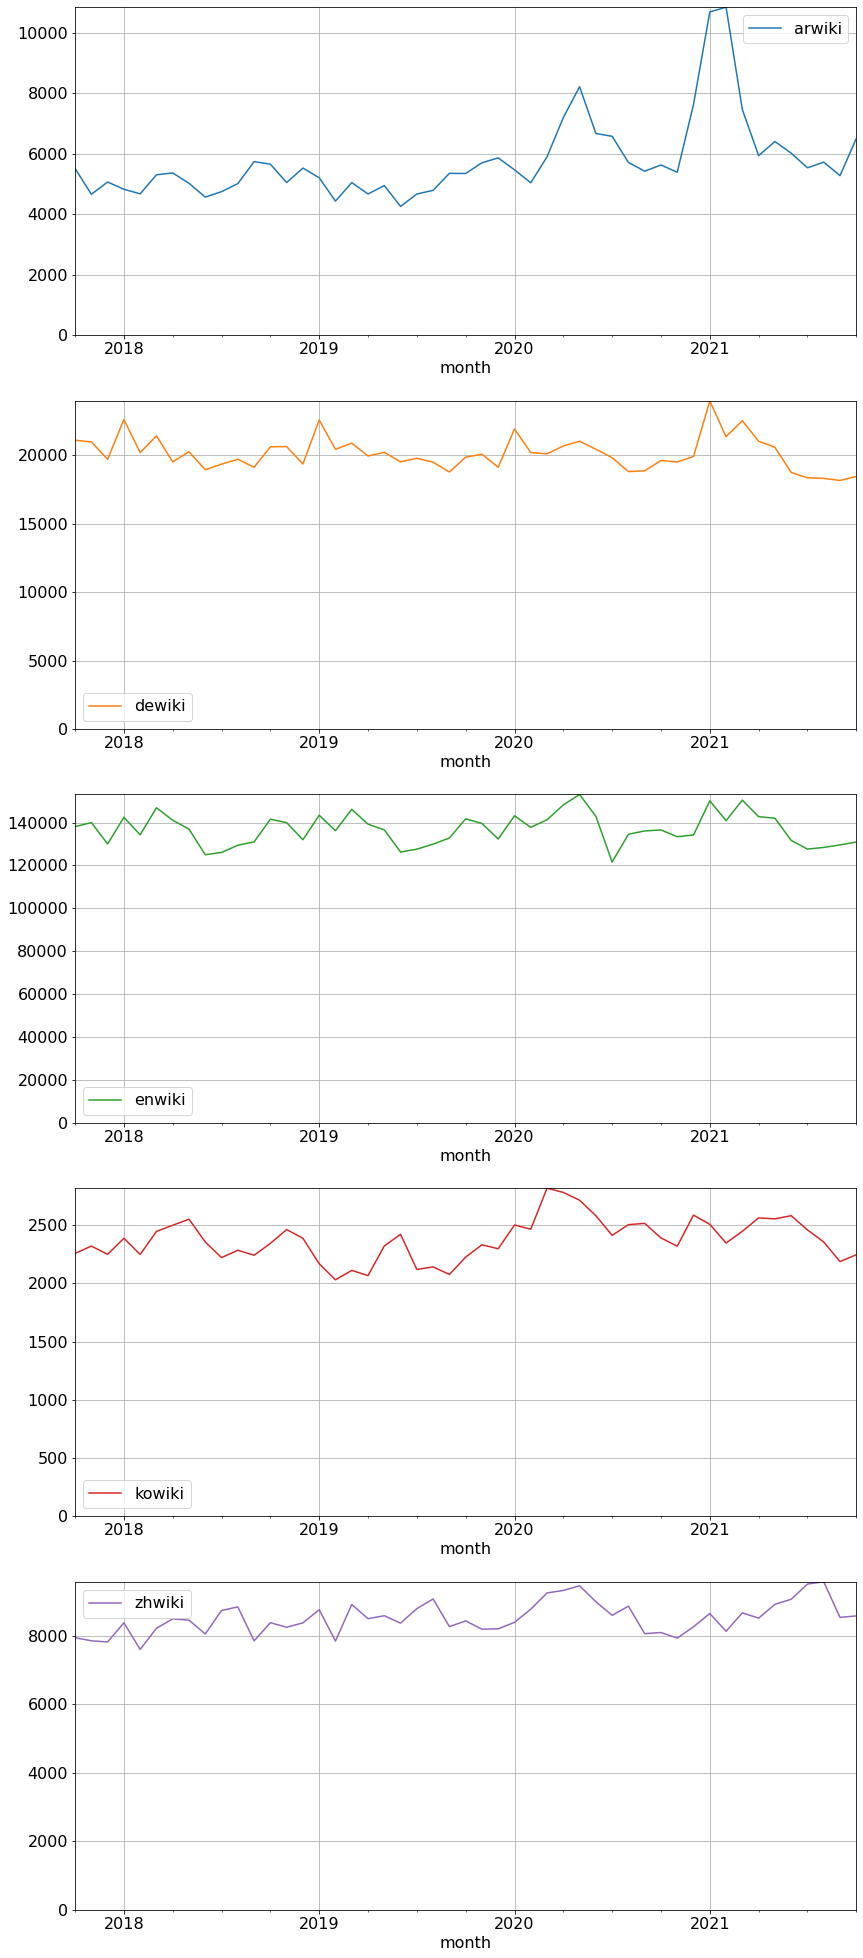

In [20]:
editors_per_wiki[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 35),
    sharex=False
);